# Tweet Sentiment and Stock Market Change Analysis for Donald Trump
### Dependencies
##### Un-comment to run as-needed

In [261]:
#somewhat uncommon libs used in this notebook:
#!pip install text
#!pip install yfinance
#!pip install vaderSentiment
#!pip install GetOldTweets3
#!pip install textblob
#!pip install unicodedata
#!pip install -U spacy
#!python -m spacy download en

### Imports

In [269]:
#imports and workbook config
import GetOldTweets3 as got
from textblob import TextBlob
import pandas as pd
import numpy as np
import datetime
import time
import warnings
import matplotlib
import matplotlib.pyplot as plt
import unicodedata
import spacy
from spacy.matcher import PhraseMatcher
import nltk
import re as re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (20,10) #(12, 6)
matplotlib.rcParams['font.size'] = 10

#establish criteria for extracting tweets using GetOldTweets3 library
nTweets = 14000

today = datetime.datetime.today().strftime('%Y-%m-%d')
tweetCriteria = got.manager.TweetCriteria().setUsername("realDonaldTrump")\
                                           .setSince("2017-01-20")\
                                           .setUntil(today)                         

### Tweet Extraction Using Getoldtweets3
##### Note: this is time-consuming and a previous extraction can be imported below from csv

In [ ]:
#fetch tweets according to the criteria above
tweet = got.manager.TweetManager.getTweets(tweetCriteria)
print(len(tweet))


In [ ]:
#Perform sample textblob sentiment analysis on latest 10 tweets
#something of a basic functional check
for i in range(0, 10): 
    print(tweet[i].text)
    print('-----------------------')
    print(TextBlob(tweet[i].text).sentiment)
    print('-----------------------')


In [ ]:
#extract content from tweets, append to lists
ids = []
permalinks = []
usernames = []
whoto = []
tweettext = []
tweetdate = []
Retweets = []
Favorites = []
Mentions = []
Hashtags = []
Geo = []

#loop through tweets, extract data item from each tweet and put in list
for i in range(0,len(tweet)):
    ids.append(tweet[i].id)
    permalinks.append(tweet[i].permalink)
    usernames.append(tweet[i].username)
    whoto.append(tweet[i].to)
    tweettext.append(tweet[i].text)
    tweetdate.append(tweet[i].date)
    Retweets.append(tweet[i].retweets)
    Favorites.append(tweet[i].favorites)
    Mentions.append(tweet[i].mentions)
    Hashtags.append(tweet[i].hashtags)
    Geo.append(tweet[i].geo)
    

In [ ]:
#zip tweet data lists into dataframe
df = pd.DataFrame(list(zip(ids,
                           permalinks,
                           usernames,
                           whoto,
                           tweettext,
                           tweetdate,
                           Retweets,
                           Favorites,
                           Mentions,
                           Hashtags,
                           Geo
                          )),
                  columns = ['ids',
                             'permalinks',
                             'usernames',
                             'whoto',
                             'tweettext',
                             'tweetdate',
                             'Retweets',
                             'Favorites',
                             'Mentions',
                             'Hashtags',
                             'Geo'])
tweets = df[['ids','tweettext','tweetdate','Retweets','Geo','Favorites']]
tweets



In [ ]:
#Created new dictionary to hold above variables
trump_tweets = {
                "ID":ids,
                "Tweet" : tweettext,
                "Date" : tweetdate,
                "Retweets" : Retweets,
                "Likes" : Favorites,
                }
trump_tweets = pd.DataFrame(trump_tweets)
#trump_tweets = trump_tweets['Tweet'].str.lower()
trump_tweets.Tweet = trump_tweets.Tweet.str.lower()
trump_tweets
trump_tweets.to_csv("output/Twitter_RawData.csv", index=False, header=True,encoding='utf-8-sig')


## Import tweets from CSV (alternate method of import)
### Feature Engineering
##### Analyze tweets for date of effect

In [95]:
#Instead of importing tweets directly from Get Old Tweets (time consuming), import from prior tweet export to CSV
trump_tweets=pd.read_csv('output/Twitter_RawData.csv')
trump_tweets

,ID,Tweet,Date,Retweets,Likes
0,1261079096404123648,great work @owens_minor! on behalf of the amer...,2020-05-14 23:41:00+00:00,12603,47573
1,1260987576300625920,"just landed in pennsylvania, see everyone soon!",2020-05-14 17:37:20+00:00,12751,60298
2,1260984775524769798,"on my way, see you soon!",2020-05-14 17:26:13+00:00,9056,49590
3,1260981100806934528,on my way to pennsylvania!,2020-05-14 17:11:36+00:00,13490,83972
4,1260958236313862151,NaN,2020-05-14 15:40:45+00:00,15340,54660
...,...,...,...,...,...
11447,822501939267141634,"power from washington, d.c. and giving it back...",2017-01-20 17:51:58+00:00,15523,80877
11448,822501803615014918,today we are not merely transferring power fro...,2017-01-20 17:51:25+00:00,17109,97893
11449,822421390125043713,it all begins today! i will see you at 11:00 a...,2017-01-20 12:31:53+00:00,59988,240191
11450,822298747421986828,thank you for a wonderful evening in washingto...,2017-01-20 04:24:33+00:00,17653,100282


In [96]:
#datetime column requires cleanup in order to operate on it
trump_tweets["Date"].astype('str', copy = True)
trump_tweets["DateTrimmed"] = trump_tweets["Date"].apply(lambda x: x[:19])
trump_tweets["DateFormatted"] = trump_tweets["DateTrimmed"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

In [97]:
#define function to determine the business day the tweet would affect the market
#accounts for nights/fridays/weekends and assumes any after-hours tweeting would affect the next business day
#agnostic of holidays so that is one minor shortcoming (approx 4 federal monday holidays per year)
#note stock market closes at 4pm

def findmarketdate(date):
    if (date.strftime('%A') in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]) and (int(date.strftime('%H')) < 16):
        return date.strftime('%Y-%m-%d')
    elif (date.strftime('%A') in ["Monday", "Tuesday", "Wednesday", "Thursday"]) and (int(date.strftime('%H')) > 16):
        return (date + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    elif (date.strftime('%A') == "Friday") and (int(date.strftime('%H')) > 16):
        return (date + datetime.timedelta(days=3)).strftime('%Y-%m-%d')
    elif (date.strftime('%A') == "Saturday"):
        return (date + datetime.timedelta(days=2)).strftime('%Y-%m-%d')
    else:
        return (date + datetime.timedelta(days=1)).strftime('%Y-%m-%d')

In [98]:
#apply findmarketdate function to formatted date column
trump_tweets["MarketDate"] = trump_tweets["DateFormatted"].apply(findmarketdate)
trump_tweets.drop(columns = ["DateTrimmed", "DateFormatted"], inplace = True)
trump_tweets
#apply findmarketdate to date tweet was created
#trump_tweets["MarketDate"] = trump_tweets['Date'].apply(findmarketdate)

,ID,Tweet,Date,Retweets,Likes,MarketDate
0,1261079096404123648,great work @owens_minor! on behalf of the amer...,2020-05-14 23:41:00+00:00,12603,47573,2020-05-15
1,1260987576300625920,"just landed in pennsylvania, see everyone soon!",2020-05-14 17:37:20+00:00,12751,60298,2020-05-15
2,1260984775524769798,"on my way, see you soon!",2020-05-14 17:26:13+00:00,9056,49590,2020-05-15
3,1260981100806934528,on my way to pennsylvania!,2020-05-14 17:11:36+00:00,13490,83972,2020-05-15
4,1260958236313862151,NaN,2020-05-14 15:40:45+00:00,15340,54660,2020-05-14
...,...,...,...,...,...,...
11447,822501939267141634,"power from washington, d.c. and giving it back...",2017-01-20 17:51:58+00:00,15523,80877,2017-01-23
11448,822501803615014918,today we are not merely transferring power fro...,2017-01-20 17:51:25+00:00,17109,97893,2017-01-23
11449,822421390125043713,it all begins today! i will see you at 11:00 a...,2017-01-20 12:31:53+00:00,59988,240191,2017-01-20
11450,822298747421986828,thank you for a wonderful evening in washingto...,2017-01-20 04:24:33+00:00,17653,100282,2017-01-20


### Perform sentiment analysis on tweets

In [99]:
trump_tweets = trump_tweets.astype(str)

In [100]:
#perform sentiment analysis on tweets using VADER
#VADER provides a positive, negative, and neutral sentiment scalar, as well as a compound sentiment vector that combines the three
analyzer = SentimentIntensityAnalyzer()

def clean_tweet(tweet):
    return ' '.join(re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', tweet).split())

trump_tweets["Tweets"] = trump_tweets['Tweet'].apply(lambda x: clean_tweet(x))
trump_tweets

def analyze_sentiment(tweet):
    analysis = TextBlob(tweet)
    
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity ==0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply Textblob sentiment anaylsis to the tweet
trump_tweets["Sentiment"] = trump_tweets['Tweet'].apply(lambda x: analyze_sentiment(x))

trump_tweets

,ID,Tweet,Date,Retweets,Likes,MarketDate,Tweets,Sentiment
0,1261079096404123648,great work @owens_minor! on behalf of the amer...,2020-05-14 23:41:00+00:00,12603,47573,2020-05-15,great work minor on behalf of the american peo...,Positive
1,1260987576300625920,"just landed in pennsylvania, see everyone soon!",2020-05-14 17:37:20+00:00,12751,60298,2020-05-15,just landed in pennsylvania see everyone soon,Neutral
2,1260984775524769798,"on my way, see you soon!",2020-05-14 17:26:13+00:00,9056,49590,2020-05-15,on my way see you soon,Neutral
3,1260981100806934528,on my way to pennsylvania!,2020-05-14 17:11:36+00:00,13490,83972,2020-05-15,on my way to pennsylvania,Neutral
4,1260958236313862151,nan,2020-05-14 15:40:45+00:00,15340,54660,2020-05-14,nan,Neutral
...,...,...,...,...,...,...,...,...
11447,822501939267141634,"power from washington, d.c. and giving it back...",2017-01-20 17:51:58+00:00,15523,80877,2017-01-23,power from washington d c and giving it back t...,Neutral
11448,822501803615014918,today we are not merely transferring power fro...,2017-01-20 17:51:25+00:00,17109,97893,2017-01-23,today we are not merely transferring power fro...,Positive
11449,822421390125043713,it all begins today! i will see you at 11:00 a...,2017-01-20 12:31:53+00:00,59988,240191,2017-01-20,it all begins today i will see you at 11 00 a ...,Neutral
11450,822298747421986828,thank you for a wonderful evening in washingto...,2017-01-20 04:24:33+00:00,17653,100282,2017-01-20,thank you for a wonderful evening in washingto...,Positive


### Analyze tweets for keywords

In [101]:
#example keywords used in analysis
keywords=pd.read_csv('output/keywords.csv').dropna()
keywords["keywords"][:10]

1       earnings
2       election
3        futures
4       investor
5            low
6         market
7         nasdaq
11        market
12    correction
13       trading
Name: keywords, dtype: object

In [102]:
#keywords = ['sad','earnings', 'election', 'futures', 'investor', 'low', 'market', 'nasdaq', 'north korea', 
#'stock','market', 'correction', 'trading', 'unemployment','wall street','china','ban','bull', 'kim', 'price', 
#'high', 'corporate', 'global warming', 'tariff', 'tax cut', 'jobs', 'economy', 'trade', 'missile', 'nuclear',
#'wages','maga','rates', 'inflation', 'growth', 'dollar', 'Fed', 'Powell', 'Xi', 'tariffs', 'impeach', 'intent', 'continue', 
#'receive', 'hundred', 'billion', 'take', 'unfair', 'practice', 'currency', 'manipulation', 'stop', 'many', 
#'media','great','today','fake','big','russia','democrats','country','time','failing','obamacare','america','foxandfriends',
#'house','nytimes','make','united','healthcare','forward','white','win ','security','tax','judge','minister','deal','decision','wall',' 
#'obama','national','support','border','tonight','republicans','washington','administration','optimism','government','executive','talk','vote','illegal']

In [103]:
#find keywords in tweets...long runtime due to checking for all keywords in all tweets

filtered_tweet_texts = []
filtered_created_date =[]
filtered_retweets=[]
filtered_likes=[]
filtered_id=[]
filtered_sentiment=[]
keys=[]
#Variables to hold sentiment analysis
compound_list = []
pos_list = []
neu_list = []
neg_list = []

# Looping through tweets
for tweet in trump_tweets.iterrows():
    for key in keywords['keywords']:
        #Used regular expression to find specific tweets based on keyword
        if re.search(key,tweet[1]['Tweets']):
            #Not all tweets will have keyword, catching tweets that match
            try:
                filtered_id.append(tweet[1]["ID"])
                filtered_tweet_texts.append(tweet[1]["Tweets"])
                filtered_created_date.append(tweet[1]["MarketDate"])
                filtered_retweets.append(tweet[1]["Retweets"])
                filtered_likes.append(tweet[1]["Likes"])
                filtered_sentiment.append(tweet[1]["Sentiment"])
                keys.append(key)
                # Performed sentiment analysis using Vader
                compound = analyzer.polarity_scores(tweet[1]["Tweets"])["compound"]
                pos = analyzer.polarity_scores(tweet[1]["Tweets"])["pos"]
                neu = analyzer.polarity_scores(tweet[1]["Tweets"])["neu"]
                neg = analyzer.polarity_scores(tweet[1]["Tweets"])["neg"]
                compound_list.append(compound)
                pos_list.append(pos)
                neu_list.append(neu)
                neg_list.append(neg)
#                 i += 1   
            except:
                    print('Missing Data')
filtered_trump_tweets = {
                "ID":filtered_id,
                "Tweet" : filtered_tweet_texts,
                "MarketDate" : filtered_created_date,
                "Retweets" : filtered_retweets,
                "Likes" : filtered_likes,
                "Keyword" : keys,
                "Positive" : pos_list,
                "Negative" : neg_list,
                "Neutral" : neu_list,
                "Compound" : compound_list,
                "Sentiment":filtered_sentiment
    
                }

#Convert dictionary to dataframe
filtered_trump_tweets = pd.DataFrame(filtered_trump_tweets)

In [104]:
#Clean, convert dtypes, add features
filtered_trump_tweets[["Likes", "Retweets"]] = filtered_trump_tweets[["Likes", "Retweets"]].apply(pd.to_numeric)
filtered_trump_tweets["TweetLength"] = filtered_trump_tweets["Tweet"].apply(lambda x: len(x))
filtered_trump_tweets.to_csv('output/Filtered_tweets_1.csv', encoding = "utf-8", index=False, header = True)


In [105]:
filtered_trump_tweets

,ID,Tweet,MarketDate,Retweets,Likes,Keyword,Positive,Negative,Neutral,Compound,Sentiment,TweetLength
0,1260912207027675136,i don t know the so called whistleblower rick ...,2020-05-14,28447,135321,low,0.035,0.166,0.799,-0.8008,Positive,243
1,1260578860992737285,as i have said for a long time dealing with ch...,2020-05-13,45663,184258,trade,0.107,0.038,0.855,0.6369,Positive,265
2,1260574760930545666,when the so called rich guys speak negatively ...,2020-05-13,46915,193826,market,0.153,0.000,0.847,0.8265,Positive,261
3,1260574760930545666,when the so called rich guys speak negatively ...,2020-05-13,46915,193826,market,0.153,0.000,0.847,0.8265,Positive,261
4,1260559055988408321,newly released documents show schiff knew all ...,2020-05-13,48889,181761,wall,0.000,0.109,0.891,-0.2960,Positive,116
...,...,...,...,...,...,...,...,...,...,...,...,...
6566,823146987117772800,had a great meeting at cia headquarters yester...,2017-01-23,14228,113792,wall,0.542,0.000,0.458,0.9633,Positive,131
6567,822774162011910144,a fantastic day and evening in washington d c ...,2017-01-23,19924,159589,many,0.317,0.000,0.683,0.8807,Positive,125
6568,822502887477673984,we will follow two simple rules buy american h...,2017-01-23,32216,143486,low,0.000,0.000,1.000,0.0000,Neutral,79
6569,822502601304526848,we will bring back our jobs we will bring back...,2017-01-23,31632,154896,jobs,0.204,0.000,0.796,0.7096,Neutral,122


### Analyze tweets for nicknames

In [106]:
#cleaner function to remove citation numbers from nicknames
def WikiNameCleaner(arr):
    name_cleaned = [];
    for name in arr:
        ref = name.find('[')
        name_cleaned.append(name[0:ref])

    return name_cleaned

#cleaner function to unpack multiple names per person into separate list elements
def Splitter(arr):
    splitlist =[]
    #check if '/' char in line--wikipedia uses these to separate multiple nicknames per person
    #killing 2 birds with 1 stone by eliminating whitespace at the same time
    for line in arr:
        if (line.count('/ ') != 0) :
            temp = line.rsplit('/ ')
            for tmp in temp:
                splitlist.append(tmp)
        else: 
            splitlist.append(line)
    return splitlist

In [107]:
#establish a class that consists of cleaned up lists of names from the wikipedia page
url = 'https://en.wikipedia.org/wiki/List_of_nicknames_used_by_Donald_Trump'
class keywordListGen:
    def func(index):
        return WikiNameCleaner(Splitter(pd.read_html(url)[index]['Nickname']))

In [281]:
#list of the tables found on the wikipedia page given by url
nicknameKeys = ["domestic_figures","foreign_figures", "media_figures","groups","other_people","organizations","tv","misc"]

#placeholder list for values that will be obtained in the for loop below
nicknameVals = []

#instantiate class created above by iterating through  list of tables in the url
for i in range(0,len(nicknameKeys)):
    nicknameVals.append(keywordListGen.func(i))

#create a dictionary from the two lists
nicknameDict = dict(zip(nicknameKeys,nicknameVals))
nicknameDict
#filtered_trump_tweets["Tweet"][0].split( )

{'domestic_figures': ['Dumbo',
  "Where's Hunter",
  '1 Percent Biden',
  '1 Percent Joe',
  'China Joe',
  'Crazy',
  'Sleepy Joe Biden',
  'Quid Pro Joe',
  'Very Slow Sleepy Joe',
  'SleepyCreepy Joe',
  'Little Michael Bloomberg',
  'Mini Mike',
  'Mini Mike Bloomberg',
  'Da Nang Richard',
  'Da Nang Dick',
  'Mr. Tough Guy',
  'Gov. Jerry "Moonbeam" Brown',
  'Bush Original',
  'Low Energy Jeb',
  'Boot-Edge-Edge',
  'Bootedgeedge',
  'Mayor Pete',
  'Alfred E. Neuman',
  "Sleepin' Bob Casey",
  'Wild Bill',
  'Skank',
  'Crazy',
  'Crooked',
  'Heartless',
  "Lyin' Hillary",
  "Leakin'",
  'Lying',
  'Sanctimonious',
  'Shady',
  'Slippery James Comey',
  "Liddle' Bob Corker",
  "Lyin' Ted",
  "Sleepin' Joe",
  'Dicky Durbin',
  'Leaking',
  'Sneaky',
  'Jeff Flakey',
  'Rejected Senator Jeff Flake',
  'Al Frankenstein',
  'Lightweight Senator Kirsten Gillibrand',
  'Puppet Jones',
  'Corrupt Kaine',
  '1 for 38',
  '1 for 41',
  '1 for 44',
  'American Fraud',
  'Lamb the Sham'

In [298]:
nlp = en_core_web_sm.load()
phrase_matcher = PhraseMatcher(nlp.vocab)

sampletext = "The Radical Left Lamestream Media, together with their partner, the , Do Nothing Democrats, are trying to spread a new narrative that President Trump was slow in reacting to Covid 19. Wrong, I was very fast, even doing the Ban on China long before anybody thought necessary!"

patternholder = []

for key in nicknameKeys:
    phrases = nicknameDict[key]
    patterns = [nlp(text.lower()) for text in phrases]
    phrase_matcher.add('AI', None, *patterns)

def applyNLP(tweet):
    matchCounter = 0
    sentence = nlp(tweet.lower())
    matched_phrases = phrase_matcher(sentence)
    
    if matched_phrases:
        matchCounter += 1
    return matchCounter

In [299]:
applyNLP(sampletext)

1

In [301]:
filtered_trump_tweets["nNicknames"] = filtered_trump_tweets["Tweet"].apply(lambda x: applyNLP(x))

In [302]:
filtered_trump_tweets

,ID,Tweet,MarketDate,Retweets,Likes,Keyword,Positive,Negative,Neutral,Compound,Sentiment,TweetLength,Nicknames,nNicknames
0,1260912207027675136,i don t know the so called whistleblower rick ...,2020-05-14,28447,135321,low,0.035,0.166,0.799,-0.8008,Positive,243,[],0
1,1260578860992737285,as i have said for a long time dealing with ch...,2020-05-13,45663,184258,trade,0.107,0.038,0.855,0.6369,Positive,265,[],1
2,1260574760930545666,when the so called rich guys speak negatively ...,2020-05-13,46915,193826,market,0.153,0.000,0.847,0.8265,Positive,261,[],0
3,1260574760930545666,when the so called rich guys speak negatively ...,2020-05-13,46915,193826,market,0.153,0.000,0.847,0.8265,Positive,261,[],0
4,1260559055988408321,newly released documents show schiff knew all ...,2020-05-13,48889,181761,wall,0.000,0.109,0.891,-0.2960,Positive,116,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6566,823146987117772800,had a great meeting at cia headquarters yester...,2017-01-23,14228,113792,wall,0.542,0.000,0.458,0.9633,Positive,131,[],0
6567,822774162011910144,a fantastic day and evening in washington d c ...,2017-01-23,19924,159589,many,0.317,0.000,0.683,0.8807,Positive,125,[],0
6568,822502887477673984,we will follow two simple rules buy american h...,2017-01-23,32216,143486,low,0.000,0.000,1.000,0.0000,Neutral,79,[],0
6569,822502601304526848,we will bring back our jobs we will bring back...,2017-01-23,31632,154896,jobs,0.204,0.000,0.796,0.7096,Neutral,122,[],0


In [250]:
def tweetSplit(tweet):
    result = []
    for word in range(0, len(tweet.split( ))):  
        for k, v in nicknameDict.items():
            if word in v:
                result.append(k)
    return result
    

filtered_trump_tweets["Nicknames"] = filtered_trump_tweets["Tweet"].apply(lambda x: tweetSplit(x))
filtered_trump_tweets["nNicknames"] = filtered_trump_tweets["Nicknames"].apply(lambda x: len(x))
filtered_trump_tweets["nNicknames"].value_counts()

0    6571
Name: nNicknames, dtype: int64

## Twitter Data Cleaning and additional feature engineering

In [121]:
# Grouping by Tweets and concatenating keywords
grouped_keywords = filtered_trump_tweets.groupby(['Tweet'])['Keyword'].apply(list).reset_index()


#merged grouped data frame with filtered data frame
merged_table = pd.merge(grouped_keywords, filtered_trump_tweets, on="Tweet")


#Dropped unwanted column
merged_table = merged_table.drop(['Keyword_y'], axis=1)

#Dropped duplicate tweets
merged_table=merged_table.drop_duplicates(['Tweet'], keep='first', inplace=False).reset_index()

#def countNicknames(tweet):
#    if

def countKeywords(x):
    return len(x)

def convertInt(x):
    return x.as_type('int64')


merged_table["nKeywords"] = merged_table["Keyword_x"].apply(lambda x: countKeywords(x))
merged_table.dtypes

index            int64
Tweet           object
Keyword_x       object
ID              object
MarketDate      object
Retweets         int64
Likes            int64
Positive       float64
Negative       float64
Neutral        float64
Compound       float64
Sentiment       object
TweetLength      int64
nKeywords        int64
dtype: object

## Aggregation and more feature engineering at aggregate level
##### Stock market data is aggregated daily so tweet data must match

In [122]:
#Aggregate by Date
grouped_date_0 = merged_table.groupby(['MarketDate']).agg({"Compound":"std"}).apply(list).reset_index()
grouped_date = merged_table.groupby(['MarketDate']).agg({"Compound":"mean",
                                                   "Tweet":"count",
                                                   "Retweets": "sum",
                                                   "Likes":"sum",
                                                   "TweetLength":"mean",
                                                  "nKeywords": "sum"}).apply(list).reset_index()
grouped_date_0.fillna(0, inplace = True)
grouped_date_0.rename(columns = {"Compound":"Sentiment_STDev"},inplace = True)
grouped_date.rename(columns = {"Compound": "Vader_Sentiment_Compound"}, inplace = True)

grouped_date = grouped_date.merge(grouped_date_0, how = "outer")
grouped_date

,MarketDate,Vader_Sentiment_Compound,Tweet,Retweets,Likes,TweetLength,nKeywords,Sentiment_STDev
0,2017-01-20,-0.250000,1,59988,240191,106.000000,1,0.000000
1,2017-01-23,0.368950,6,159004,918515,121.666667,6,0.682573
2,2017-01-24,0.273200,1,20136,138132,135.000000,1,0.000000
3,2017-01-25,0.136075,4,105165,504774,109.500000,6,0.447687
4,2017-01-26,-0.299533,3,70582,329960,120.000000,6,0.362071
...,...,...,...,...,...,...,...,...
780,2020-05-08,0.278667,3,83046,351645,166.000000,3,0.786195
781,2020-05-11,0.105250,8,225852,815993,176.375000,11,0.648822
782,2020-05-12,0.715667,6,108525,475271,216.333333,13,0.138807
783,2020-05-13,0.268820,5,203851,800036,205.600000,6,0.739390


In [123]:
#Get the dates with extreme sentiment scores (>0.5 or <-0.5)
extreme_dates1 = grouped_date[(grouped_date['Vader_Sentiment_Compound'] >= .5) | (grouped_date['Vader_Sentiment_Compound'] <= -.5)].reset_index()
#extreme_dates1

## Import Previously-Extracted Stock Market Data from CSV
##### Minor cleaning of this data to dropNA's and rename columns

In [126]:
#Import from stock market index data csv
Index_data=pd.read_csv('output/Index_Sector_Raw_data.csv')
Index_data_modified = Index_data.drop(columns=['NASDAQ_Date', 
                         'S&P500_Date',
                        'CBOE_Voltality_index_Date', 
                         'Russell2000_Date'
                        ])

#dropNA's
Index_data_modified=Index_data_modified.dropna(axis=0)

#rename columns
Index_data_new = Index_data_modified.rename(columns={'DOWJONES_Date':'Date'})
Index_data_new


,Unnamed: 0,Date,DOWJONES_Open,DowJONES_Close,DJI_Returns,NASDAQ_Open,NASDAQ_Close,NASDAQ_Returns,S&P500_Open,S&P500_Close,S&P500_Returns,CBOE_Voltality_index_Open,CBOE_Voltality_index_Close,CBOE_Voltality_index_Returns,Russell2000_Open,Russell2000_Close,Russell2000_Returns
0,0,2017-01-20,2269.96,2271.31,-0.000595,5556.87,5555.33,0.000277,2269.96,2271.31,-0.000595,12.58,11.54,0.082671,1345.96,1351.85,-0.004376
1,1,2017-01-23,2267.78,2265.20,0.001138,5546.64,5552.94,-0.001136,2267.78,2265.20,0.001138,12.30,11.77,0.043089,1351.41,1347.84,0.002642
2,2,2017-01-24,2267.88,2280.07,-0.005375,5568.27,5600.96,-0.005871,2267.88,2280.07,-0.005375,11.82,11.07,0.063452,1348.12,1369.21,-0.015644
3,3,2017-01-25,2288.88,2298.37,-0.004146,5635.86,5656.34,-0.003634,2288.88,2298.37,-0.004146,10.79,10.81,-0.001854,1371.11,1382.44,-0.008263
4,4,2017-01-26,2298.63,2296.68,0.000848,5666.28,5655.18,0.001959,2298.63,2296.68,0.000848,10.61,10.63,-0.001885,1382.43,1375.60,0.004941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,831,2020-05-11,2915.46,2930.19,-0.005052,9054.91,9192.34,-0.015177,2915.46,2930.19,-0.005052,28.46,27.57,0.031272,1320.37,1321.24,-0.000659
832,832,2020-05-12,2939.50,2870.12,0.023603,9225.15,9002.55,0.024130,2939.50,2870.12,0.023603,28.47,33.04,-0.160520,1322.67,1275.54,0.035632
833,833,2020-05-13,2865.86,2820.00,0.016002,9006.05,8863.17,0.015865,2865.86,2820.00,0.016002,32.74,35.28,-0.077581,1272.90,1233.25,0.031149
834,834,2020-05-14,2794.54,2852.50,-0.020740,8788.04,8943.72,-0.017715,2794.54,2852.50,-0.020740,35.16,32.61,0.072526,1226.66,1237.55,-0.008878


## Calculate intra-day, one-day, and two-day changes in valuation of various stock indices (S&P 500, DJIA, NASDAQ, CBOE, Russell 2000)

### Calculate changes in valuation for S&P500

In [127]:
SP500_same_day =[]
SP500_one_day = []
SP500_two_day =[]

for row in range(len(Index_data_new)):
   same_day_open= float(Index_data_new["S&P500_Open"][row])
   same_day_close= float(Index_data_new["S&P500_Close"][row])
   same_day_change = round(((same_day_close - same_day_open)/same_day_open ) * 100 ,2)
   SP500_same_day.append(same_day_change)
   
   if row + 1 < len(Index_data_new):
       prev_day_close= float(Index_data_new["S&P500_Close"][row])
       next_day_close = float(Index_data_new["S&P500_Close"][(row + 1)])
       one_day_change = round(((next_day_close - prev_day_close)/prev_day_close ) * 100 ,2)
       SP500_one_day.append(one_day_change)
       
   else:
       one_day_change = 0
       SP500_one_day.append(one_day_change)

   if row + 2 < len(Index_data_new):
       prev_day_close= float(Index_data_new["S&P500_Close"][row])
       
       two_day_close = float(Index_data_new["S&P500_Close"][(row + 2)])
       two_day_change = round(((two_day_close - prev_day_close)/prev_day_close ) * 100 ,2)
       SP500_two_day.append(two_day_change)
       
   else:
       two_day_change = 0
       SP500_two_day.append(two_day_change)


### Calculate changes in valuation for Dow Jones Industrial Average

In [128]:
DJ_same_day =[]
DJ_one_day = []
DJ_two_day =[]

for row in range(len(Index_data_new)):
   same_day_open= float(Index_data_new["DOWJONES_Open"][row])
   same_day_close= float(Index_data_new["DowJONES_Close"][row])
   same_day_change = round(((same_day_close - same_day_open)/same_day_open ) * 100 ,2)
   DJ_same_day.append(same_day_change)
   
   if row + 1 < len(Index_data_new):
       prev_day_close= float(Index_data_new["DowJONES_Close"][row])
       next_day_close = float(Index_data_new["DowJONES_Close"][(row + 1)])
       one_day_change = round(((next_day_close - prev_day_close)/prev_day_close ) * 100 ,2)
       DJ_one_day.append(one_day_change)
       
   else:
       one_day_change = 0
       DJ_one_day.append(one_day_change)

   if row + 2 < len(Index_data_new):
       prev_day_close= float(Index_data_new["DowJONES_Close"][row])
       
       two_day_close = float(Index_data_new["DowJONES_Close"][(row + 2)])
       two_day_change = round(((two_day_close - prev_day_close)/prev_day_close ) * 100 ,2)
       DJ_two_day.append(two_day_change)
       
   else:
       two_day_change = 0
       DJ_two_day.append(two_day_change)
   


### Calculate changes in valuation for Nasdaq

In [129]:
NASDAQ_same_day =[]
NASDAQ_one_day = []
NASDAQ_two_day =[]

for row in range(len(Index_data_new)):
   same_day_open= float(Index_data_new["NASDAQ_Open"][row])
   same_day_close= float(Index_data_new["NASDAQ_Close"][row])
   same_day_change = round(((same_day_close - same_day_open)/same_day_open ) * 100 ,2)
   NASDAQ_same_day.append(same_day_change)
   
   if row + 1 < len(Index_data_new):
       prev_day_close= float(Index_data_new["NASDAQ_Close"][row])
       next_day_close = float(Index_data_new["NASDAQ_Close"][(row + 1)])
       one_day_change = round(((next_day_close - prev_day_close)/prev_day_close ) * 100 ,2)
       NASDAQ_one_day.append(one_day_change)
       
   else:
       one_day_change = 0
       NASDAQ_one_day.append(one_day_change)

   if row + 2 < len(Index_data_new):
       prev_day_close= float(Index_data_new["NASDAQ_Close"][row])
       
       two_day_close = float(Index_data_new["NASDAQ_Close"][(row + 2)])
       two_day_change = round(((two_day_close - prev_day_close)/prev_day_close ) * 100 ,2)
       NASDAQ_two_day.append(two_day_change)
       
   else:
       two_day_change = 0
       NASDAQ_two_day.append(two_day_change)


### Calculate changes in valuation for CBOE

In [130]:
CBOE_same_day =[]
CBOE_one_day = []
CBOE_two_day =[]

for row in range(len(Index_data_new)):
   same_day_open= float(Index_data_new["CBOE_Voltality_index_Open"][row])
   same_day_close= float(Index_data_new["CBOE_Voltality_index_Close"][row])
   same_day_change = round(((same_day_close - same_day_open)/same_day_open ) * 100 ,2)
   CBOE_same_day.append(same_day_change)
   
   if row + 1 < len(Index_data_new):
       prev_day_close= float(Index_data_new["CBOE_Voltality_index_Close"][row])
       next_day_close = float(Index_data_new["CBOE_Voltality_index_Close"][(row + 1)])
       one_day_change = round(((next_day_close - prev_day_close)/prev_day_close ) * 100 ,2)
       CBOE_one_day.append(one_day_change)
       
   else:
       one_day_change = 0
       CBOE_one_day.append(one_day_change)

   if row + 2 < len(Index_data_new):
       prev_day_close= float(Index_data_new["CBOE_Voltality_index_Close"][row])
       
       two_day_close = float(Index_data_new["CBOE_Voltality_index_Close"][(row + 2)])
       two_day_change = round(((two_day_close - prev_day_close)/prev_day_close ) * 100 ,2)
       CBOE_two_day.append(two_day_change)
       
   else:
       two_day_change = 0
       CBOE_two_day.append(two_day_change)


### Calculate changes in valuation for Russell2000

In [131]:
Russell2000_same_day =[]
Russell2000_one_day = []
Russell2000_two_day =[]

for row in range(len(Index_data_new)):
   same_day_open= float(Index_data_new["Russell2000_Open"][row])
   same_day_close= float(Index_data_new["Russell2000_Close"][row])
   same_day_change = round(((same_day_close - same_day_open)/same_day_open ) * 100 ,2)
   Russell2000_same_day.append(same_day_change)
   
   if row + 1 < len(Index_data_new):
       prev_day_close= float(Index_data_new["Russell2000_Close"][row])
       next_day_close = float(Index_data_new["Russell2000_Close"][(row + 1)])
       one_day_change = round(((next_day_close - prev_day_close)/prev_day_close ) * 100 ,2)
       Russell2000_one_day.append(one_day_change)
       
   else:
       one_day_change = 0
       Russell2000_one_day.append(one_day_change)

   if row + 2 < len(Index_data_new):
       prev_day_close= float(Index_data_new["Russell2000_Close"][row])
       
       two_day_close = float(Index_data_new["Russell2000_Close"][(row + 2)])
       two_day_change = round(((two_day_close - prev_day_close)/prev_day_close ) * 100 ,2)
       Russell2000_two_day.append(two_day_change)
       
   else:
       two_day_change = 0
       Russell2000_two_day.append(two_day_change)

### Aggregate stock data into 1 dataframe

In [132]:
# Writing sector performance data to main stock data frame

Index_data_new["S&P500 Same-Day Change"] = SP500_same_day
Index_data_new["S&P500 1-Day Change"] = SP500_one_day
Index_data_new["S&P500 2-Day Change"] = SP500_two_day

Index_data_new["DJ Same-Day Change"] = DJ_same_day
Index_data_new["DJ 1-Day Change"] = DJ_one_day
Index_data_new["DJ 2-Day Change"] = DJ_two_day


Index_data_new["NAS Same-Day Change"] = NASDAQ_same_day
Index_data_new["NAS 1-Day Change"] = NASDAQ_one_day
Index_data_new["NAS 2-Day Change"] = NASDAQ_two_day

Index_data_new["CBOE Same-Day Change"] = CBOE_same_day
Index_data_new["CBOE 1-Day Change"] = CBOE_one_day
Index_data_new["CBOE 2-Day Change"] = CBOE_two_day

Index_data_new["Russell2000 Same-Day Change"] = Russell2000_same_day
Index_data_new["Russell2000 1-Day Change"] = Russell2000_one_day
Index_data_new["Russell2000 2-Day Change"] = Russell2000_two_day

Index_data_new.head()

,Unnamed: 0,Date,DOWJONES_Open,DowJONES_Close,DJI_Returns,NASDAQ_Open,NASDAQ_Close,NASDAQ_Returns,S&P500_Open,S&P500_Close,...,DJ 2-Day Change,NAS Same-Day Change,NAS 1-Day Change,NAS 2-Day Change,CBOE Same-Day Change,CBOE 1-Day Change,CBOE 2-Day Change,Russell2000 Same-Day Change,Russell2000 1-Day Change,Russell2000 2-Day Change
0,0,2017-01-20,2269.96,2271.31,-0.000595,5556.87,5555.33,0.000277,2269.96,2271.31,...,0.39,-0.03,-0.04,0.82,-8.27,1.99,-4.07,0.44,-0.30,1.28
1,1,2017-01-23,2267.78,2265.20,0.001138,5546.64,5552.94,-0.001136,2267.78,2265.20,...,1.46,0.11,0.86,1.86,-4.31,-5.95,-8.16,-0.26,1.59,2.57
2,2,2017-01-24,2267.88,2280.07,-0.005375,5568.27,5600.96,-0.005871,2267.88,2280.07,...,0.73,0.59,0.99,0.97,-6.35,-2.35,-3.97,1.56,0.97,0.47
3,3,2017-01-25,2288.88,2298.37,-0.004146,5635.86,5656.34,-0.003634,2288.88,2298.37,...,-0.16,0.36,-0.02,0.08,0.19,-1.67,-2.13,0.83,-0.49,-0.85
4,4,2017-01-26,2298.63,2296.68,0.000848,5666.28,5655.18,0.001959,2298.63,2296.68,...,-0.69,-0.20,0.10,-0.73,0.19,-0.47,11.76,-0.49,-0.36,-1.69


## Merge Tweet Data with Stock Data
##### Some cleanup required to eliminate weekends

In [134]:
# Merging Twitter data frame and Stock market data frame
merge_table = grouped_date.merge(Index_data_new, left_on= "MarketDate", right_on = "Date", how = "left")
merge_table

,MarketDate,Vader_Sentiment_Compound,Tweet,Retweets,Likes,TweetLength,nKeywords,Sentiment_STDev,Unnamed: 0,Date,...,DJ 2-Day Change,NAS Same-Day Change,NAS 1-Day Change,NAS 2-Day Change,CBOE Same-Day Change,CBOE 1-Day Change,CBOE 2-Day Change,Russell2000 Same-Day Change,Russell2000 1-Day Change,Russell2000 2-Day Change
0,2017-01-20,-0.250000,1,59988,240191,106.000000,1,0.000000,0.0,2017-01-20,...,0.39,-0.03,-0.04,0.82,-8.27,1.99,-4.07,0.44,-0.30,1.28
1,2017-01-23,0.368950,6,159004,918515,121.666667,6,0.682573,1.0,2017-01-23,...,1.46,0.11,0.86,1.86,-4.31,-5.95,-8.16,-0.26,1.59,2.57
2,2017-01-24,0.273200,1,20136,138132,135.000000,1,0.000000,2.0,2017-01-24,...,0.73,0.59,0.99,0.97,-6.35,-2.35,-3.97,1.56,0.97,0.47
3,2017-01-25,0.136075,4,105165,504774,109.500000,6,0.447687,3.0,2017-01-25,...,-0.16,0.36,-0.02,0.08,0.19,-1.67,-2.13,0.83,-0.49,-0.85
4,2017-01-26,-0.299533,3,70582,329960,120.000000,6,0.362071,4.0,2017-01-26,...,-0.69,-0.20,0.10,-0.73,0.19,-0.47,11.76,-0.49,-0.36,-1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,2020-05-08,0.278667,3,83046,351645,166.000000,3,0.786195,830.0,2020-05-08,...,-2.04,0.71,0.78,-1.30,-7.17,-1.47,18.08,2.73,-0.63,-4.07
781,2020-05-11,0.105250,8,225852,815993,176.375000,11,0.648822,831.0,2020-05-11,...,-3.76,1.52,-2.06,-3.58,-3.13,19.84,27.97,0.07,-3.46,-6.66
782,2020-05-12,0.715667,6,108525,475271,216.333333,13,0.138807,832.0,2020-05-12,...,-0.61,-2.41,-1.55,-0.65,16.05,6.78,-1.30,-3.56,-3.32,-2.98
783,2020-05-13,0.268820,5,203851,800036,205.600000,6,0.739390,833.0,2020-05-13,...,1.55,-1.59,0.91,1.71,7.76,-7.57,-9.61,-3.11,0.35,1.92


In [135]:
#check number of NAN values prior to encoding
#note these are weekend / holiday dates in the stock data
merge_table.isna().sum()

MarketDate                       0
Vader_Sentiment_Compound         0
Tweet                            0
Retweets                         0
Likes                            0
TweetLength                      0
nKeywords                        0
Sentiment_STDev                  0
Unnamed: 0                      45
Date                            45
DOWJONES_Open                   45
DowJONES_Close                  45
DJI_Returns                     45
NASDAQ_Open                     45
NASDAQ_Close                    45
NASDAQ_Returns                  45
S&P500_Open                     45
S&P500_Close                    45
S&P500_Returns                  45
CBOE_Voltality_index_Open       45
CBOE_Voltality_index_Close      45
CBOE_Voltality_index_Returns    45
Russell2000_Open                45
Russell2000_Close               45
Russell2000_Returns             45
S&P500 Same-Day Change          45
S&P500 1-Day Change             45
S&P500 2-Day Change             45
DJ Same-Day Change  

In [136]:
merge_table_noNANS = merge_table.dropna()
merge_table_noNANS

,MarketDate,Vader_Sentiment_Compound,Tweet,Retweets,Likes,TweetLength,nKeywords,Sentiment_STDev,Unnamed: 0,Date,...,DJ 2-Day Change,NAS Same-Day Change,NAS 1-Day Change,NAS 2-Day Change,CBOE Same-Day Change,CBOE 1-Day Change,CBOE 2-Day Change,Russell2000 Same-Day Change,Russell2000 1-Day Change,Russell2000 2-Day Change
0,2017-01-20,-0.250000,1,59988,240191,106.000000,1,0.000000,0.0,2017-01-20,...,0.39,-0.03,-0.04,0.82,-8.27,1.99,-4.07,0.44,-0.30,1.28
1,2017-01-23,0.368950,6,159004,918515,121.666667,6,0.682573,1.0,2017-01-23,...,1.46,0.11,0.86,1.86,-4.31,-5.95,-8.16,-0.26,1.59,2.57
2,2017-01-24,0.273200,1,20136,138132,135.000000,1,0.000000,2.0,2017-01-24,...,0.73,0.59,0.99,0.97,-6.35,-2.35,-3.97,1.56,0.97,0.47
3,2017-01-25,0.136075,4,105165,504774,109.500000,6,0.447687,3.0,2017-01-25,...,-0.16,0.36,-0.02,0.08,0.19,-1.67,-2.13,0.83,-0.49,-0.85
4,2017-01-26,-0.299533,3,70582,329960,120.000000,6,0.362071,4.0,2017-01-26,...,-0.69,-0.20,0.10,-0.73,0.19,-0.47,11.76,-0.49,-0.36,-1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,2020-05-08,0.278667,3,83046,351645,166.000000,3,0.786195,830.0,2020-05-08,...,-2.04,0.71,0.78,-1.30,-7.17,-1.47,18.08,2.73,-0.63,-4.07
781,2020-05-11,0.105250,8,225852,815993,176.375000,11,0.648822,831.0,2020-05-11,...,-3.76,1.52,-2.06,-3.58,-3.13,19.84,27.97,0.07,-3.46,-6.66
782,2020-05-12,0.715667,6,108525,475271,216.333333,13,0.138807,832.0,2020-05-12,...,-0.61,-2.41,-1.55,-0.65,16.05,6.78,-1.30,-3.56,-3.32,-2.98
783,2020-05-13,0.268820,5,203851,800036,205.600000,6,0.739390,833.0,2020-05-13,...,1.55,-1.59,0.91,1.71,7.76,-7.57,-9.61,-3.11,0.35,1.92


## Build Machine Learning Models

## GridSearchCV model

In [159]:
#choose a stock metric to classify on
def classY (y):
    if y >= 0:
        return 1
    else:
        return 0

merge_table_noNANS["yClass"] = merge_table_noNANS['DJ 2-Day Change'].apply(lambda y: classY(y))


In [207]:
#reshape into 2D array
y = merge_table_noNANS['yClass'].values.reshape(-1,1)

In [208]:
#drop columns not currently of interest to the model as features (i.e all stock columns could be used as target data)
X = merge_table_noNANS.drop(columns=['Date','Unnamed: 0', 'DOWJONES_Open', 'DowJONES_Close',
       'DJI_Returns', 'NASDAQ_Open', 'NASDAQ_Close', 'NASDAQ_Returns',
       'S&P500_Open', 'S&P500_Close', 'S&P500_Returns',
       'CBOE_Voltality_index_Open', 'CBOE_Voltality_index_Close',
       'CBOE_Voltality_index_Returns', 'Russell2000_Open', 'Russell2000_Close',
       'Russell2000_Returns', 'S&P500 Same-Day Change', 'S&P500 1-Day Change',
       'S&P500 2-Day Change', 'DJ Same-Day Change', 'DJ 1-Day Change',
       'DJ 2-Day Change', 'NAS Same-Day Change', 'NAS 1-Day Change',
       'NAS 2-Day Change', 'CBOE Same-Day Change', 'CBOE 1-Day Change',
       'CBOE 2-Day Change', 'Russell2000 Same-Day Change',
       'Russell2000 1-Day Change', 'Russell2000 2-Day Change','MarketDate','yClass'])
print(f'Feature columns:', X.columns)
X = X.values
print("-"*120)
print("X:")
print(X)

Feature columns: Index(['Vader_Sentiment_Compound', 'Tweet', 'Retweets', 'Likes', 'TweetLength',
       'nKeywords', 'Sentiment_STDev'],
      dtype='object')
------------------------------------------------------------------------------------------------------------------------
X:
[[-2.50000000e-01  1.00000000e+00  5.99880000e+04 ...  1.06000000e+02
   1.00000000e+00  0.00000000e+00]
 [ 3.68950000e-01  6.00000000e+00  1.59004000e+05 ...  1.21666667e+02
   6.00000000e+00  6.82572571e-01]
 [ 2.73200000e-01  1.00000000e+00  2.01360000e+04 ...  1.35000000e+02
   1.00000000e+00  0.00000000e+00]
 ...
 [ 7.15666667e-01  6.00000000e+00  1.08525000e+05 ...  2.16333333e+02
   1.30000000e+01  1.38806724e-01]
 [ 2.68820000e-01  5.00000000e+00  2.03851000e+05 ...  2.05600000e+02
   6.00000000e+00  7.39389976e-01]
 [-8.00800000e-01  1.00000000e+00  2.84470000e+04 ...  2.43000000e+02
   1.00000000e+00  0.00000000e+00]]


In [209]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.utils.np_utils import to_categorical

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [211]:
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [212]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1,10,100,1000], 'gamma':[.00001, .0001, .001, .01]}
grid = GridSearchCV(model, param_grid, verbose =  3)

In [166]:
grid.fit(X_train_scaled, y_train)



Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] C=1, gamma=1e-05 ................................................
[CV] .................... C=1, gamma=1e-05, score=0.602, total=   0.0s
[CV] C=1, gamma=1e-05 ................................................
[CV] .................... C=1, gamma=1e-05, score=0.605, total=   0.0s
[CV] C=1, gamma=1e-05 ................................................
[CV] .................... C=1, gamma=1e-05, score=0.603, total=   0.0s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.602, total=   0.0s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.605, total=   0.0s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.603, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ................. C=100, gamma=0.0001, score=0.603, total=   0.0s
[CV] C=100, gamma=0.001 ..............................................
[CV] .................. C=100, gamma=0.001, score=0.602, total=   0.0s
[CV] C=100, gamma=0.001 ..............................................
[CV] .................. C=100, gamma=0.001, score=0.605, total=   0.0s
[CV] C=100, gamma=0.001 ..............................................
[CV] .................. C=100, gamma=0.001, score=0.603, total=   0.0s
[CV] C=100, gamma=0.01 ...............................................
[CV] ................... C=100, gamma=0.01, score=0.602, total=   0.0s
[CV] C=100, gamma=0.01 ...............................................
[CV] ................... C=100, gamma=0.01, score=0.605, total=   0.0s
[CV] C=100, gamma=0.01 ...............................................
[CV] ................... C=100, gamma=0.01, score=0.603, total=   0.0s
[CV] C=1000, gamma=1e-05 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   45.2s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=-1, probability=False, random_state=None,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1e-05, 0.0001, 0.001, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [167]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 1, 'gamma': 1e-05}
0.6036036036036037


In [150]:
predictions = grid.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names = ["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        79
    positive       0.57      1.00      0.73       106

    accuracy                           0.57       185
   macro avg       0.29      0.50      0.36       185
weighted avg       0.33      0.57      0.42       185



## Neural Network Model with Keras Regressor and Cross-Validation with kFold

In [153]:
# set prng seed
seed = 42
np.random.seed(seed)

#redefine y as continuous variable
y = merge_table_noNANS['DJ 1-Day Change'].values.reshape(-1,1)
#split data into training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [154]:
#use KerasRegressor to provide a scalar output instead of classified output

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Create a Neural Network model here

def baseline_model():
    seqModel = Sequential()
    seqModel.add(Dense(units=10, activation='relu', input_dim=X.shape[1]))
    seqModel.add(Dense(units=10, activation='relu'))
    seqModel.add(Dense(units=1, activation = 'linear'))
    seqModel.compile(optimizer='adam',
                  loss='mse',
                  metrics=['accuracy'])
    return seqModel

estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, y, cv=kfold, n_jobs=1)

#FitModel = seqModel.fit(
#    X_train_scaled, 
#    y_train, 
#    epochs = 100, 
#    shuffle=True,
#    verbose=0,
#    validation_data = (X_test_scaled, y_test_scaled))

In [155]:
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -866934970.22 (2443439163.61) MSE


In [156]:
model_loss, model_accuracy = seqModel.evaluate(X_test_scaled, y_test_scaled, verbose=2)
print(f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

NameError: name 'seqModel' is not defined

## Neural Network with Linear Output

In [336]:
# set prng seed
seed = 42
np.random.seed(seed)

#redefine y as continuous variable
y = merge_table_noNANS['DJ 2-Day Change'].values.reshape(-1,1)

X = merge_table_noNANS.drop(columns=['Date','Unnamed: 0', 'DOWJONES_Open', 'DowJONES_Close',
       'DJI_Returns', 'NASDAQ_Open', 'NASDAQ_Close', 'NASDAQ_Returns',
       'S&P500_Open', 'S&P500_Close', 'S&P500_Returns',
       'CBOE_Voltality_index_Open', 'CBOE_Voltality_index_Close',
       'CBOE_Voltality_index_Returns', 'Russell2000_Open', 'Russell2000_Close',
       'Russell2000_Returns', 'S&P500 Same-Day Change', 'S&P500 1-Day Change',
       'S&P500 2-Day Change', 'DJ Same-Day Change', 'DJ 1-Day Change',
       'DJ 2-Day Change', 'NAS Same-Day Change', 'NAS 1-Day Change',
       'NAS 2-Day Change', 'CBOE Same-Day Change', 'CBOE 1-Day Change',
       'CBOE 2-Day Change', 'Russell2000 Same-Day Change',
       'Russell2000 1-Day Change', 'Russell2000 2-Day Change','MarketDate','yClass'])
print(f'Feature columns:', X.columns)
X = X.values
print("-"*120)
print("X:")
print(X)
merge_table_noNANS["yClass"] = merge_table_noNANS['DJ 1-Day Change'].apply(lambda y: classY(y))
y = merge_table_noNANS["yClass"].values.reshape(-1,1)
y

Feature columns: Index(['Vader_Sentiment_Compound', 'Tweet', 'Retweets', 'Likes', 'TweetLength',
       'nKeywords', 'Sentiment_STDev'],
      dtype='object')
------------------------------------------------------------------------------------------------------------------------
X:
[[-2.50000000e-01  1.00000000e+00  5.99880000e+04 ...  1.06000000e+02
   1.00000000e+00  0.00000000e+00]
 [ 3.68950000e-01  6.00000000e+00  1.59004000e+05 ...  1.21666667e+02
   6.00000000e+00  6.82572571e-01]
 [ 2.73200000e-01  1.00000000e+00  2.01360000e+04 ...  1.35000000e+02
   1.00000000e+00  0.00000000e+00]
 ...
 [ 7.15666667e-01  6.00000000e+00  1.08525000e+05 ...  2.16333333e+02
   1.30000000e+01  1.38806724e-01]
 [ 2.68820000e-01  5.00000000e+00  2.03851000e+05 ...  2.05600000e+02
   6.00000000e+00  7.39389976e-01]
 [-8.00800000e-01  1.00000000e+00  2.84470000e+04 ...  2.43000000e+02
   1.00000000e+00  0.00000000e+00]]


array([[0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
    

In [337]:
#split data into training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [338]:
seqModel = Sequential()
seqModel.add(Dense(units=X.shape[1], activation='relu', input_dim=X.shape[1]))
seqModel.add(Dense(units=8, activation='relu'))
seqModel.add(Dense(units=1, activation = 'softmax'))
seqModel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [339]:
FitModel = seqModel.fit(
    X_train_scaled, 
    y_train, 
    epochs = 50, 
    shuffle=True,
    verbose=0,
    validation_data = (X_test_scaled, y_test))

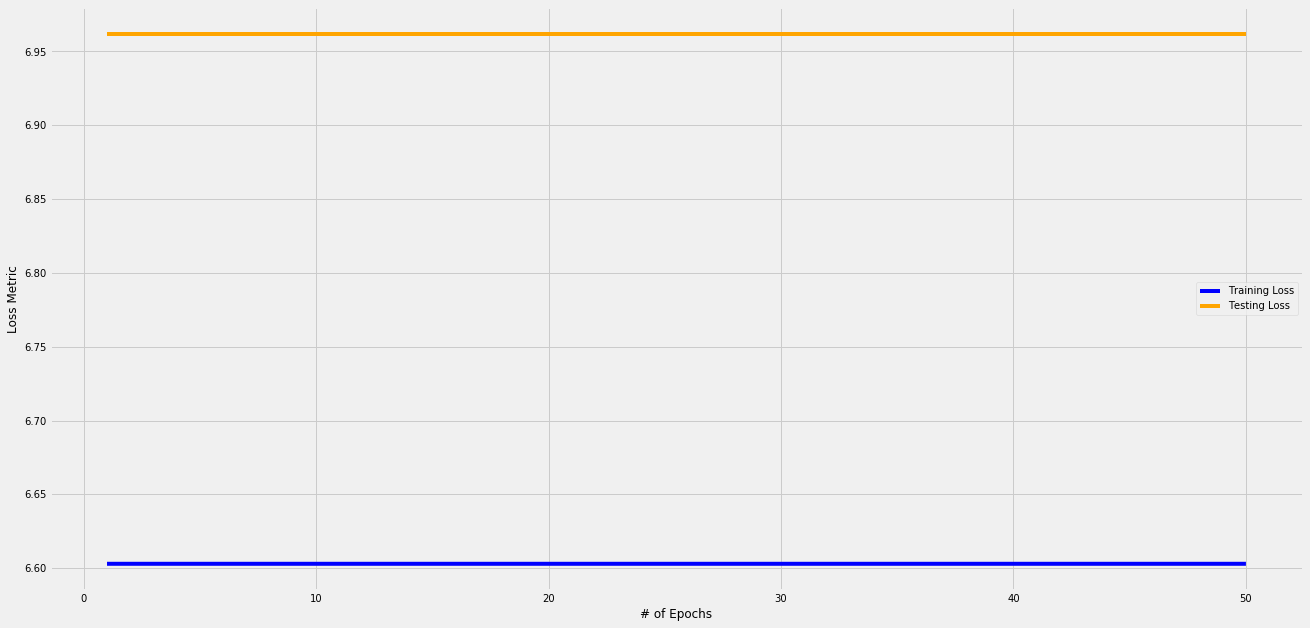

In [340]:
#Get training and test loss histories
training_loss = FitModel.history['loss']
test_loss = FitModel.history['val_loss']

#Create count of the number of epochs
#epoch count starts at 1...
xaxis = range(1, len(training_loss)+1)

#plot loss as a function of epochs
plt.plot(xaxis, training_loss, 'blue', label = "Training Loss")
plt.plot(xaxis, test_loss, 'orange', label = "Testing Loss")
plt.legend(loc = "best")
plt.xlabel('# of Epochs')
plt.ylabel('Loss Metric')
plt.show();


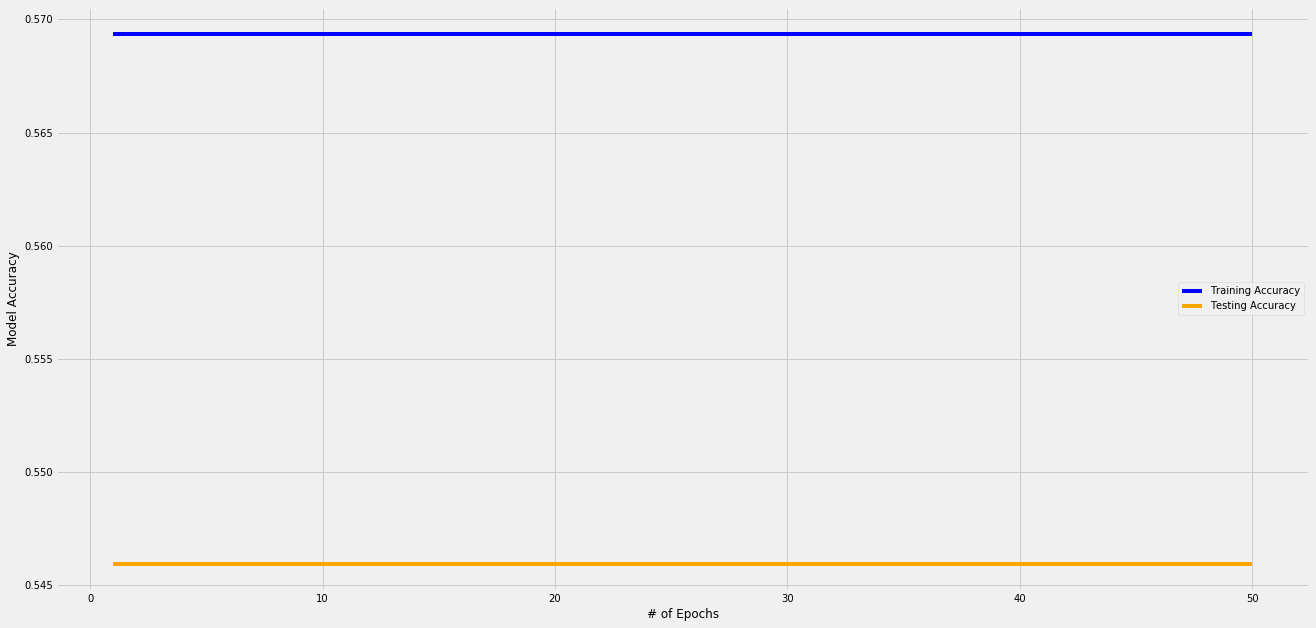

In [341]:
#Get training and testing accuracy histories
training_accuracy = FitModel.history['accuracy']
testing_accuracy = FitModel.history['val_accuracy']

#plot loss as a function of epochs
plt.plot(xaxis, training_accuracy, 'blue', label = "Training Accuracy")
plt.plot(xaxis, testing_accuracy, 'orange', label = "Testing Accuracy")
plt.legend(loc = "best")
plt.xlabel('# of Epochs')
plt.ylabel('Model Accuracy')
plt.show();
